In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(close_prices, window=14):
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20, num_std=2):
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, rolling_mean, lower_band

# Function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, signal_period=9, fast_period=12, slow_period=26):
    exp1 = close_prices.ewm(span=fast_period, adjust=False).mean()
    exp2 = close_prices.ewm(span=slow_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

# Function to calculate the Stochastic Oscillator
def calculate_stochastic_oscillator(close_prices, window=14):
    lowest_low = close_prices.rolling(window).min()
    highest_high = close_prices.rolling(window).max()
    stochastic_k = 100 * (close_prices - lowest_low) / (highest_high - lowest_low)
    stochastic_d = stochastic_k.rolling(3).mean()
    return stochastic_k, stochastic_d

# Function to calculate the Conversion Line
def calculate_conversion_line(high_prices, low_prices, window=9):
    conversion_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return conversion_line

# Function to calculate the Base Line
def calculate_base_line(high_prices, low_prices, window=26):
    base_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return base_line

# Function to calculate the Leading Span A
def calculate_leading_span_a(conversion_line, base_line):
    leading_span_a = (conversion_line + base_line) / 2
    return leading_span_a

# Function to calculate the Leading Span B
def calculate_leading_span_b(high_prices, low_prices, window=52):
    leading_span_b = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return leading_span_b

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement(high_prices, low_prices):
    price_range = high_prices - low_prices
    fibonacci_retracement = high_prices - (price_range * 0.382)  # Adjust the retracement level as needed
    return fibonacci_retracement

# Load Bitcoin price data from a CSV file
data = pd.read_csv('BTC_1M_graph_coinmarketcap.csv', delimiter=";")

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp column as the index
data.set_index('timestamp', inplace=True)

# Calculate the necessary indicators
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['close'], 14)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(data['close'], 20)
data['MACD_line'], data['MACD_signal'], _ = calculate_macd(data['close'])
data['%K'], data['%D'] = calculate_stochastic_oscillator(data['close'], 14)
data['ConversionLine'] = calculate_conversion_line(data['high'], data['low'], 9)
data['BaseLine'] = calculate_base_line(data['high'], data['low'], 26)
data['LeadingSpanA'] = calculate_leading_span_a(data['ConversionLine'], data['BaseLine'])
data['LeadingSpanB'] = calculate_leading_span_b(data['high'], data['low'], 52)
data['Fibonacci_Retracement'] = calculate_fibonacci_retracement(data['high'], data['low'])
data['Volume_MA'] = data['volume'].rolling(window=20).mean()

# Set initial capital and position size
capital = 500  # Initial capital
position_size = 0.03  # Percentage of capital to allocate per trade

# Generate trading signals
data['Signal'] = 0
position = 0  # 0: out of market, 1: long position
entry_price = 0
buy_indices = []
sell_indices = []
entry = []
exit = []

for i in range(1, len(data)):
    if (
        data['RSI'][i] < 30 and
        data['close'][i] < data['BB_lower'][i] and
        data['MACD_line'][i] > data['MACD_signal'][i] and
        data['%K'][i] > data['%D'][i] and
        data['SMA_50'][i] > data['SMA_200'][i] and                        # Adjusted RSI threshold
        data['close'][i] > data['LeadingSpanA'][i] and
        data['close'][i] > data['LeadingSpanB'][i] and
        data['close'][i] > data['Fibonacci_Retracement'][i] and
        data['volume'][i] > data['Volume_MA'][i] and
        position == 0
    ):
        # Generate a buy signal and enter a long position
        position = 1
        data['Signal'][i] = 1
        entry_price = data['close'][i]
        shares = (capital * position_size) / entry_price
        buy_indices.append(i)
        entry.append(entry_price)
        print(f'Buy at {entry_price}')

    elif (
        data['RSI'][i] > 70 and # Adjusted RSI threshold
        data['close'][i] > data['BB_upper'][i] and
        data['MACD_line'][i] < data['MACD_signal'][i] and
        data['%K'][i] < data['%D'][i] and
        data['SMA_50'][i] < data['SMA_200'][i] and
        data['close'][i] < data['LeadingSpanA'][i] and
        data['close'][i] < data['LeadingSpanB'][i] and
        data['close'][i] < data['Fibonacci_Retracement'][i] and
        data['volume'][i] < data['Volume_MA'][i] and
        position == 1
    ):
        # Generate a sell signal and exit the long position
        position = 0
        data['Signal'][i] = -1
        exit_price = data['close'][i]
        capital += shares * exit_price
        sell_indices.append(i)
        exit.append(exit_price)
        print(f'Sell at {exit_price}')

# Plotting the closing price and trading signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Closing Price')
plt.plot(data.iloc[buy_indices].index, data.iloc[buy_indices]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data.iloc[sell_indices].index, data.iloc[sell_indices]['close'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [ ]:
# profit > 300000 permonth with 500 capital -------- NOISY(BTC_1M_graph_coinmarketcap)

import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(close_prices, window=14):
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20, num_std=2):
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, rolling_mean, lower_band

# Function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, signal_period=9, fast_period=12, slow_period=26):
    exp1 = close_prices.ewm(span=fast_period, adjust=False).mean()
    exp2 = close_prices.ewm(span=slow_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

# Function to calculate the Stochastic Oscillator
def calculate_stochastic_oscillator(close_prices, window=14):
    lowest_low = close_prices.rolling(window).min()
    highest_high = close_prices.rolling(window).max()
    stochastic_k = 100 * (close_prices - lowest_low) / (highest_high - lowest_low)
    stochastic_d = stochastic_k.rolling(3).mean()
    return stochastic_k, stochastic_d

# Function to calculate the Conversion Line
def calculate_conversion_line(high_prices, low_prices, window=9):
    conversion_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return conversion_line

# Function to calculate the Base Line
def calculate_base_line(high_prices, low_prices, window=26):
    base_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return base_line

# Function to calculate the Leading Span A
def calculate_leading_span_a(conversion_line, base_line):
    leading_span_a = (conversion_line + base_line) / 2
    return leading_span_a

# Function to calculate the Leading Span B
def calculate_leading_span_b(high_prices, low_prices, window=52):
    leading_span_b = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return leading_span_b

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement(high_prices, low_prices):
    price_range = high_prices - low_prices
    fibonacci_retracement = high_prices - (price_range * 0.382)  # Adjust the retracement level as needed
    return fibonacci_retracement

# Load Bitcoin price data from a CSV file
data = pd.read_csv('BTC_1M_graph_coinmarketcap.csv', delimiter=";")

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp column as the index
data.set_index('timestamp', inplace=True)

# Calculate the necessary indicators
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['close'], 14)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(data['close'], 20)
data['MACD_line'], data['MACD_signal'], _ = calculate_macd(data['close'])
data['%K'], data['%D'] = calculate_stochastic_oscillator(data['close'], 14)
data['ConversionLine'] = calculate_conversion_line(data['high'], data['low'], 9)
data['BaseLine'] = calculate_base_line(data['high'], data['low'], 26)
data['LeadingSpanA'] = calculate_leading_span_a(data['ConversionLine'], data['BaseLine'])
data['LeadingSpanB'] = calculate_leading_span_b(data['high'], data['low'], 52)
data['Fibonacci_Retracement'] = calculate_fibonacci_retracement(data['high'], data['low'])
data['Volume_MA'] = data['volume'].rolling(window=20).mean()

# Set initial capital and position size
capital = 500  # Initial capital
position_size = 0.03  # Percentage of capital to allocate per trade

# Generate trading signals
data['Signal'] = 0
position = 0  # 0: out of market, 1: long position
entry_price = 0
buy_indices = []
sell_indices = []
entry = []
exit = []

for i in range(1, len(data)):
    if (
        data['RSI'][i] < 30 and 
        data['close'][i] < data['BB_lower'][i] and 
        data['MACD_line'][i] > data['MACD_signal'][i] and
        data['%K'][i] > data['%D'][i] or
        data['SMA_50'][i] > data['SMA_200'][i] or                        # Adjusted RSI threshold
        data['close'][i] > data['LeadingSpanA'][i] and
        data['close'][i] > data['LeadingSpanB'][i] and
        data['close'][i] > data['Fibonacci_Retracement'][i] and
        data['volume'][i] > data['Volume_MA'][i] and
        position == 0
    ):
        # Generate a buy signal and enter a long position
        position = 1
        data['Signal'][i] = 1
        entry_price = data['close'][i]
        shares = (capital * position_size) / entry_price
        buy_indices.append(i)
        entry.append(entry_price)
        print(f'Buy at {entry_price}')

    elif (
        data['RSI'][i] > 70 and # Adjusted RSI threshold
        data['close'][i] > data['BB_upper'][i] and
        data['MACD_line'][i] < data['MACD_signal'][i] and
        data['%K'][i] < data['%D'][i] or
        data['SMA_50'][i] < data['SMA_200'][i] or
        data['close'][i] < data['LeadingSpanA'][i] and
        data['close'][i] < data['LeadingSpanB'][i] and
        data['close'][i] < data['Fibonacci_Retracement'][i] and
        data['volume'][i] < data['Volume_MA'][i] and
        position == 1
    ):
        # Generate a sell signal and exit the long position
        position = 0
        data['Signal'][i] = -1
        exit_price = data['close'][i]
        capital += shares * exit_price
        sell_indices.append(i)
        exit.append(exit_price)
        print(f'Sell at {exit_price}')

# Plotting the closing price and trading signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Closing Price')
plt.plot(data.iloc[buy_indices].index, data.iloc[buy_indices]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data.iloc[sell_indices].index, data.iloc[sell_indices]['close'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [ ]:
# profit > 600000 permonth with 500 capital --------- NOISY(BTC_1M_graph_coinmarketcap)

import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(close_prices, window=14):
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20, num_std=2):
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, rolling_mean, lower_band

# Function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, signal_period=9, fast_period=12, slow_period=26):
    exp1 = close_prices.ewm(span=fast_period, adjust=False).mean()
    exp2 = close_prices.ewm(span=slow_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

# Function to calculate the Stochastic Oscillator
def calculate_stochastic_oscillator(close_prices, window=14):
    lowest_low = close_prices.rolling(window).min()
    highest_high = close_prices.rolling(window).max()
    stochastic_k = 100 * (close_prices - lowest_low) / (highest_high - lowest_low)
    stochastic_d = stochastic_k.rolling(3).mean()
    return stochastic_k, stochastic_d

# Function to calculate the Conversion Line
def calculate_conversion_line(high_prices, low_prices, window=9):
    conversion_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return conversion_line

# Function to calculate the Base Line
def calculate_base_line(high_prices, low_prices, window=26):
    base_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return base_line

# Function to calculate the Leading Span A
def calculate_leading_span_a(conversion_line, base_line):
    leading_span_a = (conversion_line + base_line) / 2
    return leading_span_a

# Function to calculate the Leading Span B
def calculate_leading_span_b(high_prices, low_prices, window=52):
    leading_span_b = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return leading_span_b

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement(high_prices, low_prices):
    price_range = high_prices - low_prices
    fibonacci_retracement = high_prices - (price_range * 0.382)  # Adjust the retracement level as needed
    return fibonacci_retracement

# Load Bitcoin price data from a CSV file
data = pd.read_csv('BTC_1M_graph_coinmarketcap.csv', delimiter=";")

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp column as the index
data.set_index('timestamp', inplace=True)

# Calculate the necessary indicators
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['close'], 14)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(data['close'], 20)
data['MACD_line'], data['MACD_signal'], _ = calculate_macd(data['close'])
data['%K'], data['%D'] = calculate_stochastic_oscillator(data['close'], 14)
data['ConversionLine'] = calculate_conversion_line(data['high'], data['low'], 9)
data['BaseLine'] = calculate_base_line(data['high'], data['low'], 26)
data['LeadingSpanA'] = calculate_leading_span_a(data['ConversionLine'], data['BaseLine'])
data['LeadingSpanB'] = calculate_leading_span_b(data['high'], data['low'], 52)
data['Fibonacci_Retracement'] = calculate_fibonacci_retracement(data['high'], data['low'])
data['Volume_MA'] = data['volume'].rolling(window=20).mean()

# Set initial capital and position size
capital = 500  # Initial capital
position_size = 0.03  # Percentage of capital to allocate per trade

# Generate trading signals
data['Signal'] = 0
position = 0  # 0: out of market, 1: long position
entry_price = 0
buy_indices = []
sell_indices = []
entry = []
exit = []

for i in range(1, len(data)):
    if (
        data['RSI'][i] < 30 and 
        data['close'][i] < data['BB_lower'][i] and 
        data['MACD_line'][i] > data['MACD_signal'][i] or
        data['%K'][i] > data['%D'][i] or
        data['SMA_50'][i] > data['SMA_200'][i] and                        # Adjusted RSI threshold
        data['close'][i] > data['LeadingSpanA'][i] and
        data['close'][i] > data['LeadingSpanB'][i] and
        data['close'][i] > data['Fibonacci_Retracement'][i] and
        data['volume'][i] > data['Volume_MA'][i] and
        position == 0
    ):
        # Generate a buy signal and enter a long position
        position = 1
        data['Signal'][i] = 1
        entry_price = data['close'][i]
        shares = (capital * position_size) / entry_price
        buy_indices.append(i)
        entry.append(entry_price)
        print(f'Buy at {entry_price}')

    elif (
        data['RSI'][i] > 70 and # Adjusted RSI threshold
        data['close'][i] > data['BB_upper'][i] and
        data['MACD_line'][i] < data['MACD_signal'][i] or
        data['%K'][i] < data['%D'][i] or
        data['SMA_50'][i] < data['SMA_200'][i] and
        data['close'][i] < data['LeadingSpanA'][i] and
        data['close'][i] < data['LeadingSpanB'][i] and
        data['close'][i] < data['Fibonacci_Retracement'][i] and
        data['volume'][i] < data['Volume_MA'][i] and
        position == 1
    ):
        # Generate a sell signal and exit the long position
        position = 0
        data['Signal'][i] = -1
        exit_price = data['close'][i]
        capital += shares * exit_price
        sell_indices.append(i)
        exit.append(exit_price)
        print(f'Sell at {exit_price}')

# Plotting the closing price and trading signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Closing Price')
plt.plot(data.iloc[buy_indices].index, data.iloc[buy_indices]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data.iloc[sell_indices].index, data.iloc[sell_indices]['close'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




C:\Users\Ink\AppData\Local\Temp\ipykernel_1936\4018660509.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = -1
C:\Users\Ink\AppData\Local\Temp\ipykernel_1936\4018660509.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 1


Sell at 28547.6342202463
Sell at 28578.4958486328
Sell at 28732.3225354446
Buy at 28325.7682398264
Buy at 29127.3266532358
Buy at 28993.4230032157
Buy at 28652.0459455576
Buy at 28633.8179709439
Buy at 28230.659926866
Buy at 28339.3788824601
Buy at 28231.781665515
Buy at 27749.0737950141
Buy at 27344.9459851908
Sell at 28177.6784170156
Sell at 28190.901757847
Buy at 27171.5842456688
Buy at 27100.362881781
Sell at 27134.7220886885
Buy at 26874.0888294738
Buy at 26859.9049540633
Sell at 26931.2945475137
Buy at 26628.2613126163
Sell at 26589.2983600882
Buy at 26325.515648831
Buy at 26294.310077321
Sell at 26782.5115006649
Sell at 26804.9906706878
Sell at 26823.2989930736
Sell at 26922.3518092577
Sell at 27089.6913005342
Sell at 27483.5628821542
Buy at 26633.6907593847
Buy at 26469.5589931441
Buy at 26620.3382287077
Sell at 27095.970826235
Sell at 27071.2474740719
Sell at 27265.917991796
Buy at 26657.882806093
Buy at 26582.703319717
Sell at 27141.5420100012
Sell at 27379.5096068142
Sell at

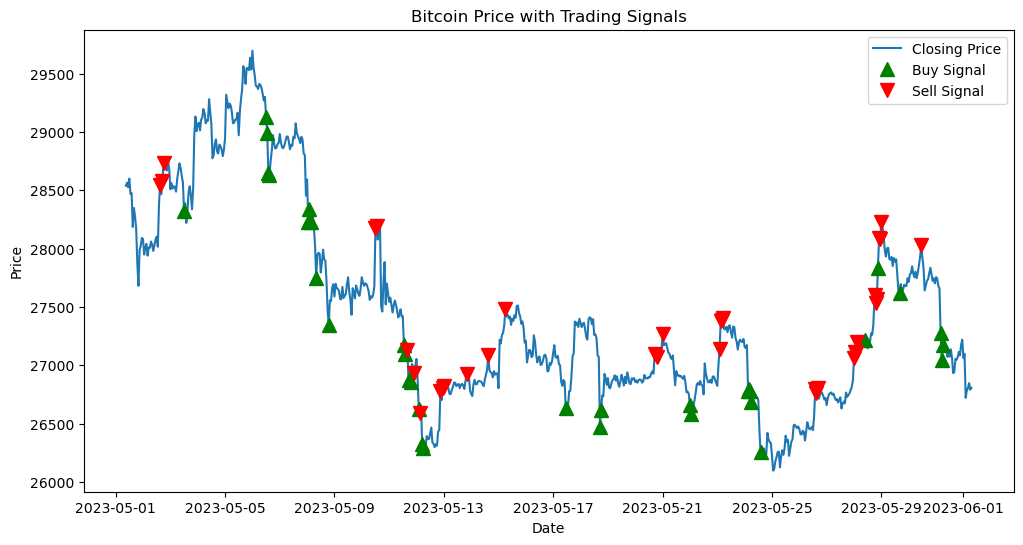

In [1]:
# profit > 50000 permonth with 500 capital --------- Non-NOISY(BTC_1M_graph_coinmarketcap)

import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(close_prices, window=14):
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20, num_std=2):
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, rolling_mean, lower_band

# Function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, signal_period=9, fast_period=12, slow_period=26):
    exp1 = close_prices.ewm(span=fast_period, adjust=False).mean()
    exp2 = close_prices.ewm(span=slow_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

# Function to calculate the Stochastic Oscillator
def calculate_stochastic_oscillator(close_prices, window=14):
    lowest_low = close_prices.rolling(window).min()
    highest_high = close_prices.rolling(window).max()
    stochastic_k = 100 * (close_prices - lowest_low) / (highest_high - lowest_low)
    stochastic_d = stochastic_k.rolling(3).mean()
    return stochastic_k, stochastic_d

# Function to calculate the Conversion Line
def calculate_conversion_line(high_prices, low_prices, window=9):
    conversion_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return conversion_line

# Function to calculate the Base Line
def calculate_base_line(high_prices, low_prices, window=26):
    base_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return base_line

# Function to calculate the Leading Span A
def calculate_leading_span_a(conversion_line, base_line):
    leading_span_a = (conversion_line + base_line) / 2
    return leading_span_a

# Function to calculate the Leading Span B
def calculate_leading_span_b(high_prices, low_prices, window=52):
    leading_span_b = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return leading_span_b

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement(high_prices, low_prices):
    price_range = high_prices - low_prices
    fibonacci_retracement = high_prices - (price_range * 0.382)  # Adjust the retracement level as needed
    return fibonacci_retracement

# Load Bitcoin price data from a CSV file
data = pd.read_csv('BTC_1M_graph_coinmarketcap.csv', delimiter=";")

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp column as the index
data.set_index('timestamp', inplace=True)

# Calculate the necessary indicators
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['close'], 14)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(data['close'], 20)
data['MACD_line'], data['MACD_signal'], _ = calculate_macd(data['close'])
data['%K'], data['%D'] = calculate_stochastic_oscillator(data['close'], 14)
data['ConversionLine'] = calculate_conversion_line(data['high'], data['low'], 9)
data['BaseLine'] = calculate_base_line(data['high'], data['low'], 26)
data['LeadingSpanA'] = calculate_leading_span_a(data['ConversionLine'], data['BaseLine'])
data['LeadingSpanB'] = calculate_leading_span_b(data['high'], data['low'], 52)
data['Fibonacci_Retracement'] = calculate_fibonacci_retracement(data['high'], data['low'])
data['Volume_MA'] = data['volume'].rolling(window=20).mean()

# Set initial capital and position size
capital = 250  # Initial capital
position_size = 0.03  # Percentage of capital to allocate per trade

# Generate trading signals
data['Signal'] = 0
position = 0  # 0: out of market, 1: long position
entry_price = 0
shares = 0
buy_indices = []
sell_indices = []
entry = []
exit = []

for i in range(1, len(data)):
    if (
        data['RSI'][i] < 30 and 
        data['close'][i] < data['BB_lower'][i] or
        data['MACD_line'][i] > data['MACD_signal'][i] and
        data['%K'][i] > data['%D'][i] and
        data['SMA_50'][i] > data['SMA_200'][i] and                        # Adjusted RSI threshold
        data['close'][i] > data['LeadingSpanA'][i] and
        data['close'][i] > data['LeadingSpanB'][i] and
        data['close'][i] > data['Fibonacci_Retracement'][i] and
        data['volume'][i] > data['Volume_MA'][i] and
        position == 0
    ):
        # Generate a buy signal and enter a long position
        position = 1
        data['Signal'][i] = 1
        entry_price = data['close'][i]
        shares = (capital * position_size) / entry_price
        buy_indices.append(i)
        entry.append(entry_price)
        print(f'Buy at {entry_price}')

    elif (
        data['RSI'][i] > 70 and # Adjusted RSI threshold
        data['close'][i] > data['BB_upper'][i] or
        data['MACD_line'][i] < data['MACD_signal'][i] and
        data['%K'][i] < data['%D'][i] and
        data['SMA_50'][i] < data['SMA_200'][i] and
        data['close'][i] < data['LeadingSpanA'][i] and
        data['close'][i] < data['LeadingSpanB'][i] and
        data['close'][i] < data['Fibonacci_Retracement'][i] and
        data['volume'][i] < data['Volume_MA'][i] and
        position == 1
    ):
        # Generate a sell signal and exit the long position
        position = 0
        data['Signal'][i] = -1
        exit_price = data['close'][i]
        capital += shares * exit_price
        shares = 0
        sell_indices.append(i)
        exit.append(exit_price)
        print(f'Sell at {exit_price}')

# Plotting the closing price and trading signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Closing Price')
plt.plot(data.iloc[buy_indices].index, data.iloc[buy_indices]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data.iloc[sell_indices].index, data.iloc[sell_indices]['close'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [ ]:
# profit > 200000 permonth with 500 capital --------- Medium-NOISY(BTC_1M_graph_coinmarketcap)

import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(close_prices, window=14):
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20, num_std=2):
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, rolling_mean, lower_band

# Function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, signal_period=9, fast_period=12, slow_period=26):
    exp1 = close_prices.ewm(span=fast_period, adjust=False).mean()
    exp2 = close_prices.ewm(span=slow_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

# Function to calculate the Stochastic Oscillator
def calculate_stochastic_oscillator(close_prices, window=14):
    lowest_low = close_prices.rolling(window).min()
    highest_high = close_prices.rolling(window).max()
    stochastic_k = 100 * (close_prices - lowest_low) / (highest_high - lowest_low)
    stochastic_d = stochastic_k.rolling(3).mean()
    return stochastic_k, stochastic_d

# Function to calculate the Conversion Line
def calculate_conversion_line(high_prices, low_prices, window=9):
    conversion_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return conversion_line

# Function to calculate the Base Line
def calculate_base_line(high_prices, low_prices, window=26):
    base_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return base_line

# Function to calculate the Leading Span A
def calculate_leading_span_a(conversion_line, base_line):
    leading_span_a = (conversion_line + base_line) / 2
    return leading_span_a

# Function to calculate the Leading Span B
def calculate_leading_span_b(high_prices, low_prices, window=52):
    leading_span_b = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return leading_span_b

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement(high_prices, low_prices):
    price_range = high_prices - low_prices
    fibonacci_retracement = high_prices - (price_range * 0.382)  # Adjust the retracement level as needed
    return fibonacci_retracement

# Load Bitcoin price data from a CSV file
data = pd.read_csv('BTC_1M_graph_coinmarketcap.csv', delimiter=";")

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp column as the index
data.set_index('timestamp', inplace=True)

# Calculate the necessary indicators
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['close'], 14)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(data['close'], 20)
data['MACD_line'], data['MACD_signal'], _ = calculate_macd(data['close'])
data['%K'], data['%D'] = calculate_stochastic_oscillator(data['close'], 14)
data['ConversionLine'] = calculate_conversion_line(data['high'], data['low'], 9)
data['BaseLine'] = calculate_base_line(data['high'], data['low'], 26)
data['LeadingSpanA'] = calculate_leading_span_a(data['ConversionLine'], data['BaseLine'])
data['LeadingSpanB'] = calculate_leading_span_b(data['high'], data['low'], 52)
data['Fibonacci_Retracement'] = calculate_fibonacci_retracement(data['high'], data['low'])
data['Volume_MA'] = data['volume'].rolling(window=20).mean()

# Set initial capital and position size
capital = 500  # Initial capital
position_size = 0.03  # Percentage of capital to allocate per trade

# Generate trading signals
data['Signal'] = 0
position = 0  # 0: out of market, 1: long position
entry_price = 0
buy_indices = []
sell_indices = []
entry = []
exit = []

for i in range(1, len(data)):
    if (
        data['RSI'][i] < 30 or
        data['close'][i] < data['BB_lower'][i] or
        data['MACD_line'][i] > data['MACD_signal'][i] and
        data['%K'][i] > data['%D'][i] and
        data['SMA_50'][i] > data['SMA_200'][i] and                        # Adjusted RSI threshold
        data['close'][i] > data['LeadingSpanA'][i] and
        data['close'][i] > data['LeadingSpanB'][i] and
        data['close'][i] > data['Fibonacci_Retracement'][i] and
        data['volume'][i] > data['Volume_MA'][i] and
        position == 0
    ):
        # Generate a buy signal and enter a long position
        position = 1
        data['Signal'][i] = 1
        entry_price = data['close'][i]
        shares = (capital * position_size) / entry_price
        buy_indices.append(i)
        entry.append(entry_price)
        print(f'Buy at {entry_price}')

    elif (
        data['RSI'][i] > 70 or # Adjusted RSI threshold
        data['close'][i] > data['BB_upper'][i] or
        data['MACD_line'][i] < data['MACD_signal'][i] and
        data['%K'][i] < data['%D'][i] and
        data['SMA_50'][i] < data['SMA_200'][i] and
        data['close'][i] < data['LeadingSpanA'][i] and
        data['close'][i] < data['LeadingSpanB'][i] and
        data['close'][i] < data['Fibonacci_Retracement'][i] and
        data['volume'][i] < data['Volume_MA'][i] and
        position == 1
    ):
        # Generate a sell signal and exit the long position
        position = 0
        data['Signal'][i] = -1
        exit_price = data['close'][i]
        capital += shares * exit_price
        sell_indices.append(i)
        exit.append(exit_price)
        print(f'Sell at {exit_price}')

# Plotting the closing price and trading signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Closing Price')
plt.plot(data.iloc[buy_indices].index, data.iloc[buy_indices]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data.iloc[sell_indices].index, data.iloc[sell_indices]['close'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [ ]:
# profit > 180000 permonth with 500 capital --------- Medium-NOISY(BTC_1M_graph_coinmarketcap)

import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(close_prices, window=14):
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20, num_std=2):
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, rolling_mean, lower_band

# Function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, signal_period=9, fast_period=12, slow_period=26):
    exp1 = close_prices.ewm(span=fast_period, adjust=False).mean()
    exp2 = close_prices.ewm(span=slow_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

# Function to calculate the Stochastic Oscillator
def calculate_stochastic_oscillator(close_prices, window=14):
    lowest_low = close_prices.rolling(window).min()
    highest_high = close_prices.rolling(window).max()
    stochastic_k = 100 * (close_prices - lowest_low) / (highest_high - lowest_low)
    stochastic_d = stochastic_k.rolling(3).mean()
    return stochastic_k, stochastic_d

# Function to calculate the Conversion Line
def calculate_conversion_line(high_prices, low_prices, window=9):
    conversion_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return conversion_line

# Function to calculate the Base Line
def calculate_base_line(high_prices, low_prices, window=26):
    base_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return base_line

# Function to calculate the Leading Span A
def calculate_leading_span_a(conversion_line, base_line):
    leading_span_a = (conversion_line + base_line) / 2
    return leading_span_a

# Function to calculate the Leading Span B
def calculate_leading_span_b(high_prices, low_prices, window=52):
    leading_span_b = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return leading_span_b

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement(high_prices, low_prices):
    price_range = high_prices - low_prices
    fibonacci_retracement = high_prices - (price_range * 0.382)  # Adjust the retracement level as needed
    return fibonacci_retracement

# Load Bitcoin price data from a CSV file
data = pd.read_csv('BTC_1M_graph_coinmarketcap.csv', delimiter=";")

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp column as the index
data.set_index('timestamp', inplace=True)

# Calculate the necessary indicators
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['close'], 14)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(data['close'], 20)
data['MACD_line'], data['MACD_signal'], _ = calculate_macd(data['close'])
data['%K'], data['%D'] = calculate_stochastic_oscillator(data['close'], 14)
data['ConversionLine'] = calculate_conversion_line(data['high'], data['low'], 9)
data['BaseLine'] = calculate_base_line(data['high'], data['low'], 26)
data['LeadingSpanA'] = calculate_leading_span_a(data['ConversionLine'], data['BaseLine'])
data['LeadingSpanB'] = calculate_leading_span_b(data['high'], data['low'], 52)
data['Fibonacci_Retracement'] = calculate_fibonacci_retracement(data['high'], data['low'])
data['Volume_MA'] = data['volume'].rolling(window=20).mean()

# Set initial capital and position size
capital = 500  # Initial capital
position_size = 0.03  # Percentage of capital to allocate per trade

# Generate trading signals
data['Signal'] = 0
position = 0  # 0: out of market, 1: long position
entry_price = 0
buy_indices = []
sell_indices = []
entry = []
exit = []

for i in range(1, len(data)):
    if (
        data['RSI'][i] < 30 or
        data['close'][i] < data['BB_lower'][i] and
        data['MACD_line'][i] > data['MACD_signal'][i] and
        data['%K'][i] > data['%D'][i] and
        data['SMA_50'][i] > data['SMA_200'][i] and                        # Adjusted RSI threshold
        data['close'][i] > data['LeadingSpanA'][i] and
        data['close'][i] > data['LeadingSpanB'][i] and
        data['close'][i] > data['Fibonacci_Retracement'][i] and
        data['volume'][i] > data['Volume_MA'][i] and
        position == 0
    ):
        # Generate a buy signal and enter a long position
        position = 1
        data['Signal'][i] = 1
        entry_price = data['close'][i]
        shares = (capital * position_size) / entry_price
        buy_indices.append(i)
        entry.append(entry_price)
        print(f'Buy at {entry_price}')

    elif (
        data['RSI'][i] > 70 or # Adjusted RSI threshold
        data['close'][i] > data['BB_upper'][i] and
        data['MACD_line'][i] < data['MACD_signal'][i] and
        data['%K'][i] < data['%D'][i] and
        data['SMA_50'][i] < data['SMA_200'][i] and
        data['close'][i] < data['LeadingSpanA'][i] and
        data['close'][i] < data['LeadingSpanB'][i] and
        data['close'][i] < data['Fibonacci_Retracement'][i] and
        data['volume'][i] < data['Volume_MA'][i] and
        position == 1
    ):
        # Generate a sell signal and exit the long position
        position = 0
        data['Signal'][i] = -1
        exit_price = data['close'][i]
        capital += shares * exit_price
        sell_indices.append(i)
        exit.append(exit_price)
        print(f'Sell at {exit_price}')

# Plotting the closing price and trading signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Closing Price')
plt.plot(data.iloc[buy_indices].index, data.iloc[buy_indices]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data.iloc[sell_indices].index, data.iloc[sell_indices]['close'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [ ]:
# profit > 800 permonth with 500 capital --------- Non-NOISY(BTC_1M_graph_coinmarketcap)

import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(close_prices, window=14):
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20, num_std=2):
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, rolling_mean, lower_band

# Function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, signal_period=9, fast_period=12, slow_period=26):
    exp1 = close_prices.ewm(span=fast_period, adjust=False).mean()
    exp2 = close_prices.ewm(span=slow_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

# Function to calculate the Stochastic Oscillator
def calculate_stochastic_oscillator(close_prices, window=14):
    lowest_low = close_prices.rolling(window).min()
    highest_high = close_prices.rolling(window).max()
    stochastic_k = 100 * (close_prices - lowest_low) / (highest_high - lowest_low)
    stochastic_d = stochastic_k.rolling(3).mean()
    return stochastic_k, stochastic_d

# Function to calculate the Conversion Line
def calculate_conversion_line(high_prices, low_prices, window=9):
    conversion_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return conversion_line

# Function to calculate the Base Line
def calculate_base_line(high_prices, low_prices, window=26):
    base_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return base_line

# Function to calculate the Leading Span A
def calculate_leading_span_a(conversion_line, base_line):
    leading_span_a = (conversion_line + base_line) / 2
    return leading_span_a

# Function to calculate the Leading Span B
def calculate_leading_span_b(high_prices, low_prices, window=52):
    leading_span_b = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return leading_span_b

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement(high_prices, low_prices):
    price_range = high_prices - low_prices
    fibonacci_retracement = high_prices - (price_range * 0.382)  # Adjust the retracement level as needed
    return fibonacci_retracement

# Load Bitcoin price data from a CSV file
data = pd.read_csv('BTC_1M_graph_coinmarketcap.csv', delimiter=";")

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp column as the index
data.set_index('timestamp', inplace=True)

# Calculate the necessary indicators
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['close'], 14)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(data['close'], 20)
data['MACD_line'], data['MACD_signal'], _ = calculate_macd(data['close'])
data['%K'], data['%D'] = calculate_stochastic_oscillator(data['close'], 14)
data['ConversionLine'] = calculate_conversion_line(data['high'], data['low'], 9)
data['BaseLine'] = calculate_base_line(data['high'], data['low'], 26)
data['LeadingSpanA'] = calculate_leading_span_a(data['ConversionLine'], data['BaseLine'])
data['LeadingSpanB'] = calculate_leading_span_b(data['high'], data['low'], 52)
data['Fibonacci_Retracement'] = calculate_fibonacci_retracement(data['high'], data['low'])
data['Volume_MA'] = data['volume'].rolling(window=20).mean()

# Set initial capital and position size
capital = 500  # Initial capital
position_size = 0.03  # Percentage of capital to allocate per trade

# Generate trading signals
data['Signal'] = 0
position = 0  # 0: out of market, 1: long position
entry_price = 0
buy_indices = []
sell_indices = []
entry = []
exit = []

for i in range(1, len(data)):
    if (
        data['RSI'][i] < 30 and
        data['close'][i] < data['BB_lower'][i] and
        data['MACD_line'][i] > data['MACD_signal'][i] and
        data['%K'][i] > data['%D'][i] and
        data['SMA_50'][i] > data['SMA_200'][i] and                        # Adjusted RSI threshold
        data['close'][i] > data['LeadingSpanA'][i] and
        data['close'][i] > data['LeadingSpanB'][i] and
        data['close'][i] > data['Fibonacci_Retracement'][i] or
        data['volume'][i] > data['Volume_MA'][i] and
        position == 0
    ):
        # Generate a buy signal and enter a long position
        position = 1
        data['Signal'][i] = 1
        entry_price = data['close'][i]
        shares = (capital * position_size) / entry_price
        buy_indices.append(i)
        entry.append(entry_price)
        print(f'Buy at {entry_price}')

    elif (
        data['RSI'][i] > 70 and # Adjusted RSI threshold
        data['close'][i] > data['BB_upper'][i] and
        data['MACD_line'][i] < data['MACD_signal'][i] and
        data['%K'][i] < data['%D'][i] and
        data['SMA_50'][i] < data['SMA_200'][i] and
        data['close'][i] < data['LeadingSpanA'][i] and
        data['close'][i] < data['LeadingSpanB'][i] and
        data['close'][i] < data['Fibonacci_Retracement'][i] or
        data['volume'][i] < data['Volume_MA'][i] and
        position == 1
    ):
        # Generate a sell signal and exit the long position
        position = 0
        data['Signal'][i] = -1
        exit_price = data['close'][i]
        capital += shares * exit_price
        sell_indices.append(i)
        exit.append(exit_price)
        print(f'Sell at {exit_price}')

# Plotting the closing price and trading signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Closing Price')
plt.plot(data.iloc[buy_indices].index, data.iloc[buy_indices]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data.iloc[sell_indices].index, data.iloc[sell_indices]['close'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [4]:
buy = sum(entry)
sell = sum(exit)
print("used money to buy:", entry)
print("")
print('total:', buy)
print("")
print("")
print("")
print("used money to sell:", exit)
print("")
print('total:', sell)
print("")
print("")
print("")
print("Profit:", sell - buy)

used money to buy: [28325.7682398264, 29127.3266532358, 28993.4230032157, 28652.0459455576, 28633.8179709439, 28230.659926866, 28339.3788824601, 28231.781665515, 27749.0737950141, 27344.9459851908, 27171.5842456688, 27100.362881781, 26874.0888294738, 26859.9049540633, 26628.2613126163, 26325.515648831, 26294.310077321, 26633.6907593847, 26469.5589931441, 26620.3382287077, 26657.882806093, 26582.703319717, 26782.8137255677, 26798.881335422, 26777.2868308982, 26685.8428245898, 26253.7540579536, 27218.3657926041, 27834.8723501821, 27618.2088085646, 27277.9533932364, 27043.6912679304, 27170.5398698679]

total: 901308.6343814437



used money to sell: [28547.6342202463, 28578.4958486328, 28732.3225354446, 28177.6784170156, 28190.901757847, 27134.7220886885, 26931.2945475137, 26589.2983600882, 26782.5115006649, 26804.9906706878, 26823.2989930736, 26922.3518092577, 27089.6913005342, 27483.5628821542, 27095.970826235, 27071.2474740719, 27265.917991796, 27141.5420100012, 27379.5096068142, 27388

C:\Users\Ink\AppData\Local\Temp\ipykernel_9940\1807449590.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = -1
C:\Users\Ink\AppData\Local\Temp\ipykernel_9940\1807449590.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 1


Sell at 28547.6342202463
Sell at 28578.4958486328
Sell at 28732.3225354446
Buy at 28325.7682398264
Buy at 29127.3266532358
Buy at 28993.4230032157
Buy at 28652.0459455576
Buy at 28633.8179709439
Buy at 28230.659926866
Buy at 28339.3788824601
Buy at 28231.781665515
Buy at 27749.0737950141
Buy at 27344.9459851908
Sell at 28177.6784170156
Sell at 28190.901757847
Buy at 27171.5842456688
Buy at 27100.362881781
Sell at 27134.7220886885
Buy at 26874.0888294738
Buy at 26859.9049540633
Sell at 26931.2945475137
Buy at 26628.2613126163
Sell at 26589.2983600882
Buy at 26325.515648831
Buy at 26294.310077321
Sell at 26782.5115006649
Sell at 26804.9906706878
Sell at 26823.2989930736
Sell at 26922.3518092577
Sell at 27089.6913005342
Sell at 27483.5628821542
Buy at 26633.6907593847
Buy at 26469.5589931441
Buy at 26620.3382287077
Sell at 27095.970826235
Sell at 27071.2474740719
Sell at 27265.917991796
Buy at 26657.882806093
Buy at 26582.703319717
Sell at 27141.5420100012
Sell at 27379.5096068142
Sell at

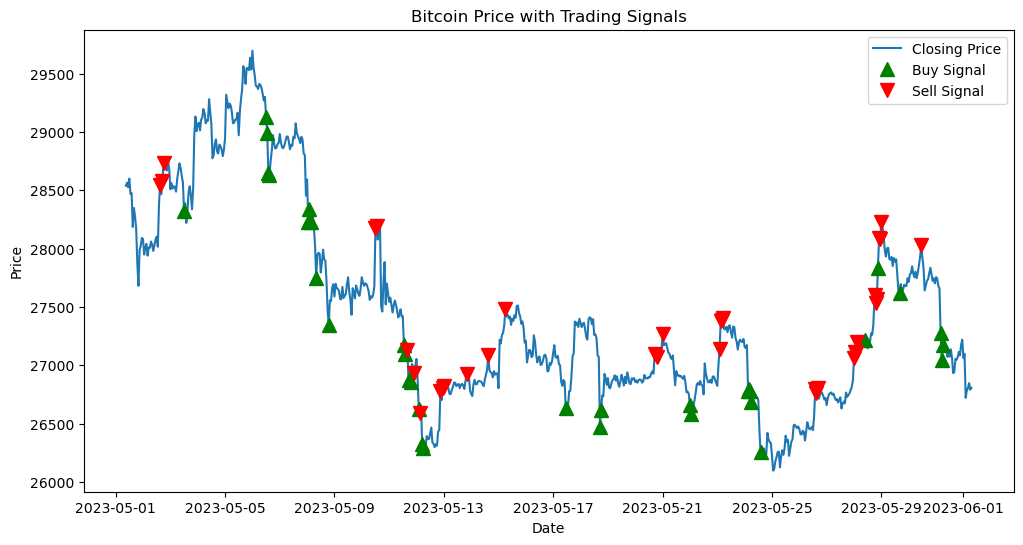

In [3]:
# profit > 50000 permonth with 500 capital --------- Non-NOISY(BTC_1M_graph_coinmarketcap)

import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(close_prices, window=14):
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate the Bollinger Bands
def calculate_bollinger_bands(close_prices, window=20, num_std=2):
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, rolling_mean, lower_band

# Function to calculate the Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, signal_period=9, fast_period=12, slow_period=26):
    exp1 = close_prices.ewm(span=fast_period, adjust=False).mean()
    exp2 = close_prices.ewm(span=slow_period, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

# Function to calculate the Stochastic Oscillator
def calculate_stochastic_oscillator(close_prices, window=14):
    lowest_low = close_prices.rolling(window).min()
    highest_high = close_prices.rolling(window).max()
    stochastic_k = 100 * (close_prices - lowest_low) / (highest_high - lowest_low)
    stochastic_d = stochastic_k.rolling(3).mean()
    return stochastic_k, stochastic_d

# Function to calculate the Conversion Line
def calculate_conversion_line(high_prices, low_prices, window=9):
    conversion_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return conversion_line

# Function to calculate the Base Line
def calculate_base_line(high_prices, low_prices, window=26):
    base_line = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return base_line

# Function to calculate the Leading Span A
def calculate_leading_span_a(conversion_line, base_line):
    leading_span_a = (conversion_line + base_line) / 2
    return leading_span_a

# Function to calculate the Leading Span B
def calculate_leading_span_b(high_prices, low_prices, window=52):
    leading_span_b = (high_prices.rolling(window).max() + low_prices.rolling(window).min()) / 2
    return leading_span_b

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement(high_prices, low_prices):
    price_range = high_prices - low_prices
    fibonacci_retracement = high_prices - (price_range * 0.382)  # Adjust the retracement level as needed
    return fibonacci_retracement

# Load Bitcoin price data from a CSV file
data = pd.read_csv('BTC_1M_graph_coinmarketcap.csv', delimiter=";")

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set the timestamp column as the index
data.set_index('timestamp', inplace=True)

# Calculate the necessary indicators
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['close'], 14)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = calculate_bollinger_bands(data['close'], 20)
data['MACD_line'], data['MACD_signal'], _ = calculate_macd(data['close'])
data['%K'], data['%D'] = calculate_stochastic_oscillator(data['close'], 14)
data['ConversionLine'] = calculate_conversion_line(data['high'], data['low'], 9)
data['BaseLine'] = calculate_base_line(data['high'], data['low'], 26)
data['LeadingSpanA'] = calculate_leading_span_a(data['ConversionLine'], data['BaseLine'])
data['LeadingSpanB'] = calculate_leading_span_b(data['high'], data['low'], 52)
data['Fibonacci_Retracement'] = calculate_fibonacci_retracement(data['high'], data['low'])
data['Volume_MA'] = data['volume'].rolling(window=20).mean()

# Set initial capital and position size
capital = 0  # Initial capital
position_size = 0.03  # Percentage of capital to allocate per trade

# Generate trading signals
data['Signal'] = 0
position = 0  # 0: out of market, 1: long position
entry_price = 0
shares = 0
buy_indices = []
sell_indices = []
entry = []
exit = []

for i in range(1, len(data)):
    if (
        data['RSI'][i] < 30 and 
        data['close'][i] < data['BB_lower'][i] or
        data['MACD_line'][i] > data['MACD_signal'][i] and
        data['%K'][i] > data['%D'][i] and
        data['SMA_50'][i] > data['SMA_200'][i] and                        # Adjusted RSI threshold
        data['close'][i] > data['LeadingSpanA'][i] and
        data['close'][i] > data['LeadingSpanB'][i] and
        data['close'][i] > data['Fibonacci_Retracement'][i] and
        data['volume'][i] > data['Volume_MA'][i] and
        position == 0
    ):
        # Generate a buy signal and enter a long position
        position = 1
        data['Signal'][i] = 1
        entry_price = data['close'][i]
        shares = (capital * position_size) / entry_price
        buy_indices.append(i)
        entry.append(entry_price)
        print(f'Buy at {entry_price}')

    elif (
        data['RSI'][i] > 70 and # Adjusted RSI threshold
        data['close'][i] > data['BB_upper'][i] or
        data['MACD_line'][i] < data['MACD_signal'][i] and
        data['%K'][i] < data['%D'][i] and
        data['SMA_50'][i] < data['SMA_200'][i] and
        data['close'][i] < data['LeadingSpanA'][i] and
        data['close'][i] < data['LeadingSpanB'][i] and
        data['close'][i] < data['Fibonacci_Retracement'][i] and
        data['volume'][i] < data['Volume_MA'][i] and
        position == 1
    ):
        # Generate a sell signal and exit the long position
        position = 0
        data['Signal'][i] = -1
        exit_price = data['close'][i]
        capital += shares * exit_price
        shares = 0
        sell_indices.append(i)
        exit.append(exit_price)
        print(f'Sell at {exit_price}')

# Plotting the closing price and trading signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Closing Price')
plt.plot(data.iloc[buy_indices].index, data.iloc[buy_indices]['close'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data.iloc[sell_indices].index, data.iloc[sell_indices]['close'], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Bitcoin Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()